<a href="https://colab.research.google.com/github/RaminTK/TDRP/blob/main/VRP_1T.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gurobipy

# Libraries

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [ ]:
# Create an environment with your WLS license
params = {
"WLSACCESSID": 'c5c6ef9a-d24b-4e09-99ba-a30fae3c2de1',
"WLSSECRET": '3809b277-8064-4385-8804-9971d3dc9938',
"LICENSEID": 2536865,
}

# Parameters

$d_{ij}$ Travel time between node $i$ and $j$ by truck, $(i,j) \in C_0$.

$\bar{d}_{ij}$ Travel time between node $i$ and $j$ by UAV, $(i,j) \in C_0$.

$M$ A sufficiently large number.

<!-- $L$ & Battery life limit of UAV. -->

$a$ Number of aid recipients.

$K$ Number of UAVs.

$q$ Relief item capacity limit of UAVs. (unlimited)

In [ ]:
num_nodes_t = 5
num_t = 1
M = 100000  # A large number
a = num_nodes_t+1

# Sets



<!-- $V$ & Set of all nodes in the network. Elements $0$ and $a + 1$ both represent the depot. -->
$A_E$  Set of aid recipients and the depot as the starting location. $A_E = \{0, 1, 2, \dots, a\}$.

$A$  Set of aid recipients. $A = \{1, 2, \dots, a\}$. $|A|= a$.

$A_T$  Set of aid recipients served by trucks. $A_T \subset A_E$.

$A_U$  Set of aid recipients served by UAVs. $A_U \subset A_E$.


<!-- % $A_E$ & Set of aid recipients and the depot as the terminal location. $A_E = \{1, 2, \dots, a\}$. -->

$U$  Set of UAVs. $|U|= K$.

$T$  Set of trucks. $|T| = N$.

In [ ]:
A_T = list(range(num_nodes_t+2))  # Set of nodes for trucks
T = list(range(1,num_t+1))      # Set of trucks

In [ ]:
A_T,T

([0, 1, 2, 3, 4, 5, 6], [1])

## Generate random coordinates for the nodes

In [ ]:
# Number of nodes
num_nodes = num_nodes_t+1

np.random.seed(0)  # For reproducibility
coordinates = np.random.rand(num_nodes, 2) * 100  # Generate random coordinates in a 100x100 area

In [ ]:
coordinates = np.vstack([coordinates, coordinates[0]])

In [ ]:
coordinates

array([[54.88135039, 71.51893664],
       [60.27633761, 54.4883183 ],
       [42.36547993, 64.58941131],
       [43.75872113, 89.17730008],
       [96.36627605, 38.34415188],
       [79.17250381, 52.88949198],
       [54.88135039, 71.51893664]])

In [ ]:
num_nodes = num_nodes+1

## Distance Matrix


In [ ]:
euclidean_dist_matrix = distance_matrix(coordinates, coordinates)
manhattan_dist_matrix = distance_matrix(coordinates, coordinates, p=1)

In [ ]:
euclidean_df = pd.DataFrame(euclidean_dist_matrix, columns=[f'Node {i}' for i in range(num_nodes)], index=[f'Node {i}' for i in range(num_nodes)])
manhattan_df = pd.DataFrame(manhattan_dist_matrix, columns=[f'Node {i}' for i in range(num_nodes)], index=[f'Node {i}' for i in range(num_nodes)])

In [ ]:
euclidean_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Node 0,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,0.000000
Node 1,17.864710,0.000000,20.562852,38.420790,39.536284,18.963685,17.864710
Node 2,14.306129,20.562852,0.000000,24.627330,60.040816,38.621822,14.306129
Node 3,20.869372,38.420790,24.627330,0.000000,73.154383,50.704448,20.869372
Node 4,53.118409,39.536284,60.040816,73.154383,0.000000,22.520940,53.118409
Node 5,30.612356,18.963685,38.621822,50.704448,22.520940,0.000000,30.612356
Node 6,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,0.000000


In [ ]:
manhattan_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Node 0,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,0.000000
Node 1,22.425606,0.000000,28.011951,51.206598,52.234105,20.494993,22.425606
Node 2,19.445396,28.011951,0.000000,25.981130,80.246056,48.506943,19.445396
Node 3,28.780993,51.206598,25.981130,0.000000,103.440703,71.701591,28.780993
Node 4,74.659710,52.234105,80.246056,103.440703,0.000000,31.739112,74.659710
Node 5,42.920598,20.494993,48.506943,71.701591,31.739112,0.000000,42.920598
Node 6,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,0.000000


## Plot the nodes

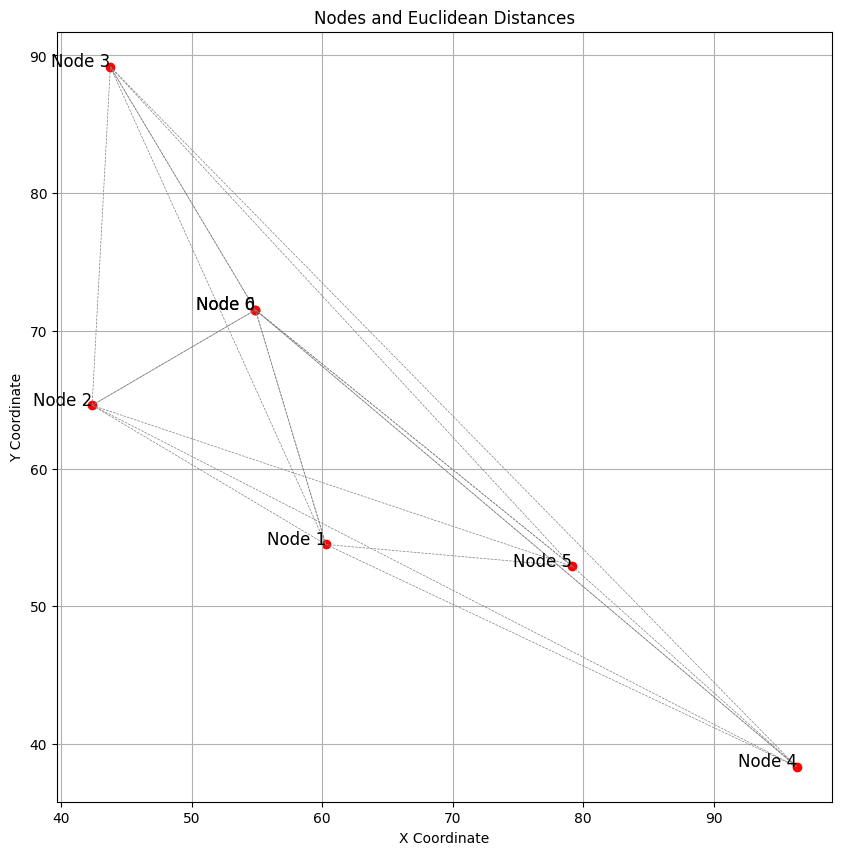

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(coordinates[:, 0], coordinates[:, 1], color='red')

# Annotate the nodes
for i, (x, y) in enumerate(coordinates):
    plt.text(x, y, f'Node {i}', fontsize=12, ha='right')

# Draw lines between nodes for Euclidean distances
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        plt.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title('Nodes and Euclidean Distances')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [ ]:
euclidean_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Node 0,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,0.000000
Node 1,17.864710,0.000000,20.562852,38.420790,39.536284,18.963685,17.864710
Node 2,14.306129,20.562852,0.000000,24.627330,60.040816,38.621822,14.306129
Node 3,20.869372,38.420790,24.627330,0.000000,73.154383,50.704448,20.869372
Node 4,53.118409,39.536284,60.040816,73.154383,0.000000,22.520940,53.118409
Node 5,30.612356,18.963685,38.621822,50.704448,22.520940,0.000000,30.612356
Node 6,0.000000,17.864710,14.306129,20.869372,53.118409,30.612356,0.000000


In [ ]:
manhattan_df

,Node 0,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Node 0,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,0.000000
Node 1,22.425606,0.000000,28.011951,51.206598,52.234105,20.494993,22.425606
Node 2,19.445396,28.011951,0.000000,25.981130,80.246056,48.506943,19.445396
Node 3,28.780993,51.206598,25.981130,0.000000,103.440703,71.701591,28.780993
Node 4,74.659710,52.234105,80.246056,103.440703,0.000000,31.739112,74.659710
Node 5,42.920598,20.494993,48.506943,71.701591,31.739112,0.000000,42.920598
Node 6,0.000000,22.425606,19.445396,28.780993,74.659710,42.920598,0.000000


In [ ]:
d_t = manhattan_df  # Travel times for trucks => will change into a matrix of Manhttan distances
d_u = euclidean_df  # Travel times for UAVs => will change into a matrix of  Euclidean distances

# Model

In [ ]:
env = gp.Env(params=params)
m = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2536865
Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu


# Indices

$i, j, h, s, g, v$  Equivalently used indices for the nodes of the network (aid recipients and depot).

$t$  Index of trucks.

$u$  Index of UAVs.

# Variables

$x^{t}_{ij}$ 1 if truck $t$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in A_E$ for $t \in T$.

$v^{t}_{ij}$ 1 if node $i$ is visited before node $j$ by truck $t$; 0 otherwise. $(i,j) \in A_T$ for $t \in T$.



$z^{t}_{i}$ Position of node $i$ in the truck $t$ route. $i \in A_E$ for $t \in T$.

$r^{t}_{i}$ Arrival time of truck $t$ at node $i$. $i \in A_E$ for $t \in T$.

$p^{t}_{i}$ Departure time of truck $t$ from node $i$. $i \in A_E$ for $t \in T$.

In [ ]:
x = m.addVars(A_T, A_T, T, vtype=GRB.BINARY, name="from i to j truck t travels") #1 if truck $w$ moves from node $i$ to node $j$; 0 otherwise. $(i,j) \in C_0$ for $w \in W$.
z = m.addVars(A_T[1:-1],T, vtype=GRB.INTEGER,lb=1.0,ub= a-1, name="order") #Position of node $i$ in the truck $w$ route. $i \in C_0$ for $w \in W$.
r_t = m.addVars(A_T,T, vtype=GRB.CONTINUOUS, lb=0.0, name="arrival time truck") #Arrival time of truck $w$ at node $i$. $i \in C_0$ for $w \in W$.
p_t = m.addVars(A_T, T, vtype=GRB.CONTINUOUS, lb=0.0, name="departure time truck") #Departure time of truck $w$ from node $i$. $i \in C_0$ for $w \in W$.
y = m.addVar(name="objective value")

# Objective Function

Min $\sum_{i \in A_T} \sum_{t \in T} r^{t}_{i}$ (1)


In [ ]:
# m.setObjective(gp.quicksum(r_t[i, t] for i in A_T[1:-1] for t in T), GRB.MINIMIZE)

$\min \max y$

In [ ]:
m.setObjective(y, GRB.MINIMIZE)

# Constraints

$r^{t}_{i, t} \leq y \quad \forall i \in A^{T}_{1:n-1}, \forall t \in T $

In [ ]:
m.addConstrs((r_t[i, t] <= y for t in T for i in A_T[1:-1]),'min maxconversion constraint')

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5): <gurobi.Constr *Awaiting Model Update*>}

$\sum_{j \in A_T} x^{t}_{0j} = 1, \forall t \in T$  (2)

In [ ]:
m.addConstrs((gp.quicksum(x[0, j, t] for j in A_T[1:-1]) == 1 for t in T), "DepartsFromDepot")

{1: <gurobi.Constr *Awaiting Model Update*>}

$\sum_{i \in C_T} x^{t}_{i,end} = 1, \forall t \in T$ (3)

In [ ]:
m.addConstrs((gp.quicksum(x[i, a, t] for i in A_T[1:-1]) == 1 for t in T), "ReturnsToDepot")

{1: <gurobi.Constr *Awaiting Model Update*>}

explain - truck self return ban

In [ ]:
m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T for j in A_T if i == j) == 0 for t in T), "explain - self return ban")

m.addConstrs((gp.quicksum(x[i, 0, t] for i in A_T[1:]) == 0 for t in T), "ReturnToStartDepot ban")
m.addConstrs((gp.quicksum(x[a, j, t] for j in A_T[:-1]) == 0 for t in T), "StartFromEndDepot ban")

{1: <gurobi.Constr *Awaiting Model Update*>}

$\sum_{g \in A_T \atop g \neq i} x^{t}_{gi} = \sum_{j \in A_U \atop j \neq i} x^{t}_{ij}, \forall i \in A_T, \forall t \in T,$ (4)

In [ ]:
m.addConstrs((gp.quicksum(x[g, i, t] for g in A_T[:-1] if g != i) == gp.quicksum(x[i, j, t] for j in A_T[1:] if j != i) for i in A_T[1:-1] for t in T), "FlowConservationTruck")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>}

 $p^{t}_{i} + d_{ij} - (1 - x^{t}_{ij}) M \leq r^{t}_{j}, \forall i \in A_T, \forall j \in A_E, i \neq j,$ (8)


In [ ]:
m.addConstrs((p_t[i, t] + d_t.iloc[i, j] - (1 - x[i, j, t]) * M <= r_t[j, t] for i in A_T[:-1] for j in A_T[1:] if i != j for t in T), "TruckArrivalTime")

{(0, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 6, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4, 1): <gurobi.Constr *Awaiting Model Upd

$r^{t}_{i} \leq p^{t}_{j}, \forall i \in A_T, \forall t \in W,$ (11)

In [ ]:
m.addConstrs((r_t[i, t] <= p_t[i, t] for i in A_T[1:-1] for t in T), "TruckDepartureTime")

{(1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1): <gurobi.Constr *Awaiting Model Update*>}

In [ ]:
m.addConstrs((gp.quicksum(x[i, j, t] for i in A_T[:-1] if i != j for t in T) == 1 for j in A_T[1:]), "VisitExactOnce - Truck")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>}

MTZ

In [ ]:
m.addConstrs(z[i,t] - z[j,t] + (a - 1) * x[i,j,t] <= a - 2 for i in A_T[1:-1] for j in A_T[1:-1] if i != j for t in T)

{(1, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 5, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (5, 3, 1): <gurobi.Constr *Awaiting Model Upd

# Optimization

In [ ]:
m.optimize()

# Display the results
if m.status == GRB.OPTIMAL:
    print("Optimal objective value is :", m.objVal)
    for v in m.getVars():
        if v.x > 0:
            print(v.varName, v.x)
else:
    print("Ther is no optimal solution.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2536865 - for non-commercial use only - registered to rt___@stevens.edu
Optimize a model with 77 rows, 69 columns and 283 nonzeros
Model fingerprint: 0xf9cbfe0e
Variable types: 15 continuous, 54 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 255.0944145
Presolve removed 15 rows and 28 columns
Presolve time: 0.00s
Presolved: 62 rows, 41 columns, 200 nonzeros
Variable types: 6 continuous, 35 integer (30 binary)

Root relaxation: objective 5.971717e+00, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp